# Andrew Pullar

# Capstone Project Source Code

# March 1, 2023

In [2]:
#load necessary libaries 
from pybaseball import batting_stats #Fangraphs data
from pybaseball import pitching_stats #Fangraphs data 
from pybaseball import bwar_bat #baseball-reference
from pybaseball import bwar_pitch #baseball-reference
from pybaseball.lahman import *
import pandas as pd
import numpy as np
import seaborn as sea
import matplotlib.pyplot as mplt
%matplotlib inline

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.svm import LinearSVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

import joblib

In [3]:
#pull MLB player hitting statistics from Fangraphs
hitstat = batting_stats(2001, 2021, ind = 1, qual = 350)

When using the batting_stats function, the parameters are set to include seasons from 2021 to 2021. The ind value of 1 indicates that data will be pulled from each season rather than aggregating the stats for the designated time. Additionally, the qual parameter sets a constraint for players who have had at least 350 plate appearances per season
(LeDoux, J., 2022).

In [4]:
#4,835 players in the 20 year period of 2001 to 2021
hitstat.shape

(4835, 319)

In [5]:
#view the hitting statistics data
hitstat.tail()

,IDfg,Season,Name,Team,Age,G,AB,PA,H,1B,...,Barrel%,maxEV,HardHit,HardHit%,Events,CStr%,CSW%,xBA,xSLG,xwOBA
4806,763,2001,Peter Bergeron,MON,23,102,375,416,79,61,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
4827,9272,2018,Chris Davis,BAL,32,128,470,522,79,51,...,0.096,111.8,113.0,0.401,282,0.174,0.316,NaN,NaN,NaN
4733,319,2011,Adam Dunn,CHW,31,122,415,496,66,39,...,NaN,NaN,0.0,NaN,0,0.169,0.295,NaN,NaN,NaN
4815,620,2002,Neifi Perez,KCR,29,145,554,585,131,104,...,NaN,NaN,NaN,NaN,0,0.130,0.187,NaN,NaN,NaN
865,2113,2008,Ryan Doumit,PIT,27,116,431,465,137,88,...,NaN,NaN,0.0,NaN,0,0.144,0.231,NaN,NaN,NaN


### Data Cleaning

In [7]:
#create dataframe using baseball reference data
baseref = bwar_bat()

In [8]:
#view end of dataset
baseref.tail()

,name_common,mlb_ID,player_ID,year_ID,team_ID,stint_ID,lg_ID,pitcher,G,PA,salary,runs_above_avg,runs_above_avg_off,runs_above_avg_def,WAR_rep,WAA,WAR
119940,Dutch Zwilling,124791.0,zwilldu01,1915,CHI,1,FL,N,150,636.0,NaN,27.6,23.6,0.1,0.97,3.17,4.14
119941,Dutch Zwilling,124791.0,zwilldu01,1916,CHC,1,NL,N,35,59.0,3250.0,-6.7,-5.7,-1.3,0.19,-0.86,-0.67
119942,Tony Zych,543964.0,zychto01,2015,SEA,1,AL,Y,0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN
119943,Tony Zych,543964.0,zychto01,2016,SEA,1,AL,Y,0,0.0,511000.0,0.0,0.0,0.0,NaN,NaN,NaN
119944,Tony Zych,543964.0,zychto01,2017,SEA,1,AL,Y,4,0.0,539600.0,0.0,0.0,0.0,0.00,0.00,0.00


In [9]:
#sort dataframe by WAR stat
war = baseref.sort_values('WAR', ascending = False)
war

,name_common,mlb_ID,player_ID,year_ID,team_ID,stint_ID,lg_ID,pitcher,G,PA,salary,runs_above_avg,runs_above_avg_off,runs_above_avg_def,WAR_rep,WAA,WAR
94156,Babe Ruth,121578.0,ruthba01,1923,NYY,1,AL,N,152,697.0,52000.0,122.1,103.1,12.1,2.62,11.54,14.16
94154,Babe Ruth,121578.0,ruthba01,1921,NYY,1,AL,N,152,693.0,20000.0,114.6,108.6,-0.7,2.47,10.40,12.87
94160,Babe Ruth,121578.0,ruthba01,1927,NYY,1,AL,N,151,691.0,70000.0,107.4,95.4,5.0,2.54,10.01,12.55
118753,Carl Yastrzemski,124650.0,yastrca01,1967,BOS,1,AL,N,161,680.0,50000.0,90.1,66.7,15.6,2.27,10.18,12.45
50042,Rogers Hornsby,116156.0,hornsro01,1924,STL,1,NL,N,143,642.0,17500.0,105.7,98.7,11.8,2.04,10.22,12.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119877,Eddie Zosky,124784.0,zoskyed01,2000,HOU,1,NL,NaN,4,4.0,NaN,-1.3,-1.3,0.0,NaN,-0.12,NaN
119892,Tyler Zuber,676604.0,zuberty01,2020,KCR,1,AL,Y,0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN
119897,Joel Zumaya,451491.0,zumayjo01,2007,DET,1,AL,Y,0,0.0,410000.0,0.0,0.0,0.0,NaN,NaN,NaN
119942,Tony Zych,543964.0,zychto01,2015,SEA,1,AL,Y,0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN


In [10]:
#filter year after 2000 and WAR greater than 1
df = war[war['year_ID'] > 2000]
df = df[df['WAR'] >= 1 ]
df

,name_common,mlb_ID,player_ID,year_ID,team_ID,stint_ID,lg_ID,pitcher,G,PA,salary,runs_above_avg,runs_above_avg_off,runs_above_avg_def,WAR_rep,WAA,WAR
9882,Barry Bonds,111188.0,bondsba01,2001,SFG,1,NL,N,153,664.0,10300000.0,106.3,110.9,-10.7,1.98,9.87,11.85
9883,Barry Bonds,111188.0,bondsba01,2002,SFG,1,NL,N,143,612.0,15000000.0,101.7,101.5,-5.2,1.87,9.88,11.75
8206,Mookie Betts,605141.0,bettsmo01,2018,BOS,1,AL,N,136,614.0,10500000.0,84.9,66.9,13.5,1.96,8.72,10.68
9885,Barry Bonds,111188.0,bondsba01,2004,SFG,1,NL,N,147,617.0,18000000.0,93.1,101.1,-13.8,1.88,8.76,10.64
55528,Aaron Judge,592450.0,judgeaa01,2022,NYY,1,AL,N,157,696.0,19000000.0,81.4,78.4,0.8,2.19,8.41,10.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25391,Ike Davis,477195.0,davisik02,2012,NYM,1,NL,N,156,584.0,506690.0,-7.5,-4.5,-10.5,1.78,-0.78,1.00
93233,David Ross,424325.0,rossda01,2003,LAD,1,NL,N,40,140.0,NaN,6.0,7.0,1.3,0.43,0.57,1.00
84882,Brandon Phillips,408252.0,phillbr01,2017,ATL,1,NL,N,120,499.0,NaN,-4.6,0.4,-2.1,1.57,-0.57,1.00
108442,Andres Torres,400083.0,torrean02,2011,SFG,1,NL,N,112,398.0,2200000.0,-1.8,-0.8,0.9,1.23,-0.23,1.00


In [11]:
df2 = df.dropna()
df2

,name_common,mlb_ID,player_ID,year_ID,team_ID,stint_ID,lg_ID,pitcher,G,PA,salary,runs_above_avg,runs_above_avg_off,runs_above_avg_def,WAR_rep,WAA,WAR
9882,Barry Bonds,111188.0,bondsba01,2001,SFG,1,NL,N,153,664.0,10300000.0,106.3,110.9,-10.7,1.98,9.87,11.85
9883,Barry Bonds,111188.0,bondsba01,2002,SFG,1,NL,N,143,612.0,15000000.0,101.7,101.5,-5.2,1.87,9.88,11.75
8206,Mookie Betts,605141.0,bettsmo01,2018,BOS,1,AL,N,136,614.0,10500000.0,84.9,66.9,13.5,1.96,8.72,10.68
9885,Barry Bonds,111188.0,bondsba01,2004,SFG,1,NL,N,147,617.0,18000000.0,93.1,101.1,-13.8,1.88,8.76,10.64
55528,Aaron Judge,592450.0,judgeaa01,2022,NYY,1,AL,N,157,696.0,19000000.0,81.4,78.4,0.8,2.19,8.41,10.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115753,Bernie Williams,124288.0,willibe02,2003,NYY,1,AL,N,119,521.0,12357143.0,-9.2,7.8,-14.6,1.83,-0.83,1.00
64496,Jed Lowrie,476704.0,lowrije01,2014,OAK,1,AL,N,136,566.0,5250000.0,-10.7,-1.7,-2.3,1.97,-0.97,1.00
25391,Ike Davis,477195.0,davisik02,2012,NYM,1,NL,N,156,584.0,506690.0,-7.5,-4.5,-10.5,1.78,-0.78,1.00
108442,Andres Torres,400083.0,torrean02,2011,SFG,1,NL,N,112,398.0,2200000.0,-1.8,-0.8,0.9,1.23,-0.23,1.00


In [13]:
df2['rWAR'] = round(df2['WAR'],0)

/var/folders/w8/52vxmf0s1sdgnnq8pmnkr7wm0000gn/T/ipykernel_29001/1847509483.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['rWAR'] = round(df2['WAR'],0)


Text(0.5, 1.0, 'Frequency of WAR Values')

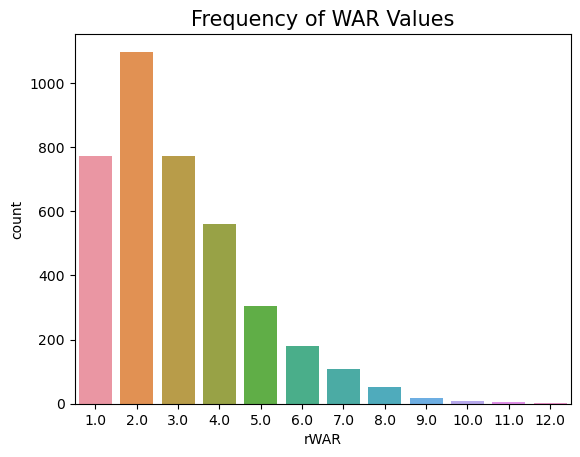

In [19]:
#display WAR
sea.countplot(x ='rWAR', data = df2)
mplt.title('Frequency of WAR Values', fontsize=15)

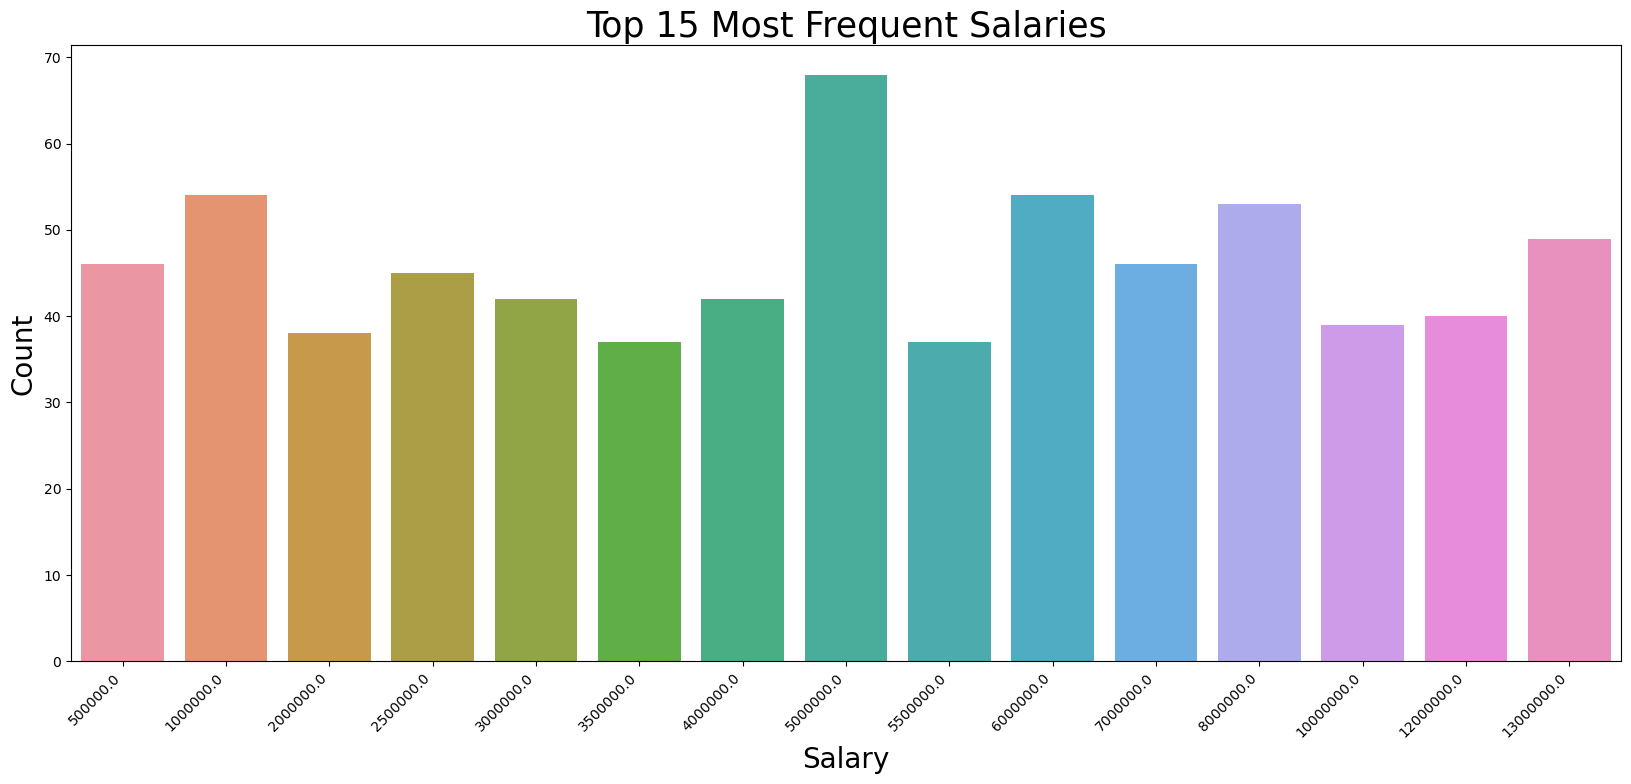

In [25]:
from collections import Counter

def top_15(data):
    salary_counts = Counter(data)
    top_15 = salary_counts.most_common(15)
    salary = [salary for salary, count in top_15]
    count = [count for salary, count in top_15]
    mplt.figure(figsize=(20, 8))
    sea.barplot(x=salary, y=count)
    mplt.xticks(rotation=45, ha='right')  # rotate the x-axis labels and align them to the right
    mplt.xlabel('Salary', fontsize=20)
    mplt.ylabel('Count', fontsize=20)
    mplt.title('Top 15 Most Frequent Salaries', fontsize=25)
    mplt.show()
 
top_15(df2['salary'])

In [28]:
#most common salary 
salary_counts = Counter(df2.salary)
salary_counts.most_common(1)


[(5000000.0, 68)]

In [16]:
import statistics
 
meansal = statistics.mean(df2.salary)
print('The average MLB salary is ', '${:,.2f}'.format(meansal))

The average MLB salary is  $5,553,397.74


In [29]:
df2.columns

Index(['name_common', 'mlb_ID', 'player_ID', 'year_ID', 'team_ID', 'stint_ID',
       'lg_ID', 'pitcher', 'G', 'PA', 'salary', 'runs_above_avg',
       'runs_above_avg_off', 'runs_above_avg_def', 'WAR_rep', 'WAA', 'WAR',
       'rWAR'],
      dtype='object')

In [30]:
df2 = df2.drop(['stint_ID', 'runs_above_avg', 'runs_above_avg_off', 'runs_above_avg_def'], axis = 1)

In [31]:
df2 = df2.drop(['WAR_rep', 'WAA'], axis = 1)

In [32]:
df2

,name_common,mlb_ID,player_ID,year_ID,team_ID,lg_ID,pitcher,G,PA,salary,WAR,rWAR
9882,Barry Bonds,111188.0,bondsba01,2001,SFG,NL,N,153,664.0,10300000.0,11.85,12.0
9883,Barry Bonds,111188.0,bondsba01,2002,SFG,NL,N,143,612.0,15000000.0,11.75,12.0
8206,Mookie Betts,605141.0,bettsmo01,2018,BOS,AL,N,136,614.0,10500000.0,10.68,11.0
9885,Barry Bonds,111188.0,bondsba01,2004,SFG,NL,N,147,617.0,18000000.0,10.64,11.0
55528,Aaron Judge,592450.0,judgeaa01,2022,NYY,AL,N,157,696.0,19000000.0,10.60,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...
115753,Bernie Williams,124288.0,willibe02,2003,NYY,AL,N,119,521.0,12357143.0,1.00,1.0
64496,Jed Lowrie,476704.0,lowrije01,2014,OAK,AL,N,136,566.0,5250000.0,1.00,1.0
25391,Ike Davis,477195.0,davisik02,2012,NYM,NL,N,156,584.0,506690.0,1.00,1.0
108442,Andres Torres,400083.0,torrean02,2011,SFG,NL,N,112,398.0,2200000.0,1.00,1.0


In [33]:
df2['player'] = df2['name_common']
df2['season'] = df2['year_ID']

df2 = df2.drop(['name_common', 'year_ID'], axis = 1)

fc = df2.pop('player')
tc = df2.pop('season')
  
# insert column using insert(position,column_name,first_column) function
df2.insert(0, 'player', fc)
df2.insert(1, 'season', tc)
df2

,player,season,mlb_ID,player_ID,team_ID,lg_ID,pitcher,G,PA,salary,WAR,rWAR
9882,Barry Bonds,2001,111188.0,bondsba01,SFG,NL,N,153,664.0,10300000.0,11.85,12.0
9883,Barry Bonds,2002,111188.0,bondsba01,SFG,NL,N,143,612.0,15000000.0,11.75,12.0
8206,Mookie Betts,2018,605141.0,bettsmo01,BOS,AL,N,136,614.0,10500000.0,10.68,11.0
9885,Barry Bonds,2004,111188.0,bondsba01,SFG,NL,N,147,617.0,18000000.0,10.64,11.0
55528,Aaron Judge,2022,592450.0,judgeaa01,NYY,AL,N,157,696.0,19000000.0,10.60,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...
115753,Bernie Williams,2003,124288.0,willibe02,NYY,AL,N,119,521.0,12357143.0,1.00,1.0
64496,Jed Lowrie,2014,476704.0,lowrije01,OAK,AL,N,136,566.0,5250000.0,1.00,1.0
25391,Ike Davis,2012,477195.0,davisik02,NYM,NL,N,156,584.0,506690.0,1.00,1.0
108442,Andres Torres,2011,400083.0,torrean02,SFG,NL,N,112,398.0,2200000.0,1.00,1.0


In [34]:
#create csv file
df2.to_csv('/Users/andrewpullar/Downloads/df2_salary')

In [35]:
salary_years = df2[(df2['season'] >= 2001) & (df2['season'] <= 2021) & (df2['PA'] >= 350)]
salary_years

,player,season,mlb_ID,player_ID,team_ID,lg_ID,pitcher,G,PA,salary,WAR,rWAR
9882,Barry Bonds,2001,111188.0,bondsba01,SFG,NL,N,153,664.0,10300000.0,11.85,12.0
9883,Barry Bonds,2002,111188.0,bondsba01,SFG,NL,N,143,612.0,15000000.0,11.75,12.0
8206,Mookie Betts,2018,605141.0,bettsmo01,BOS,AL,N,136,614.0,10500000.0,10.68,11.0
9885,Barry Bonds,2004,111188.0,bondsba01,SFG,NL,N,147,617.0,18000000.0,10.64,11.0
109110,Mike Trout,2012,545361.0,troutmi01,LAA,AL,N,139,639.0,492500.0,10.54,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...
83689,Jhonny Peralta,2009,425509.0,peraljh01,CLE,AL,N,151,645.0,3650000.0,1.00,1.0
115753,Bernie Williams,2003,124288.0,willibe02,NYY,AL,N,119,521.0,12357143.0,1.00,1.0
64496,Jed Lowrie,2014,476704.0,lowrije01,OAK,AL,N,136,566.0,5250000.0,1.00,1.0
25391,Ike Davis,2012,477195.0,davisik02,NYM,NL,N,156,584.0,506690.0,1.00,1.0


In [46]:
#use pandas library to join two tables
hitting_data = salary_years.merge(hitstat, how = 'left', 
                                  left_on = ['player', 'season'], right_on =['Name', 'Season'])


In [47]:
hitting_data

,player,season,mlb_ID,player_ID,team_ID,lg_ID,pitcher,G_x,PA_x,salary,...,Barrel%,maxEV,HardHit,HardHit%,Events,CStr%,CSW%,xBA,xSLG,xwOBA
0,Barry Bonds,2001,111188.0,bondsba01,SFG,NL,N,153,664.0,10300000.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1,Barry Bonds,2002,111188.0,bondsba01,SFG,NL,N,143,612.0,15000000.0,...,NaN,NaN,NaN,NaN,0.0,0.127,0.191,NaN,NaN,NaN
2,Mookie Betts,2018,605141.0,bettsmo01,BOS,AL,N,136,614.0,10500000.0,...,0.131,110.6,217.0,0.5,434.0,0.220,0.270,NaN,NaN,NaN
3,Barry Bonds,2004,111188.0,bondsba01,SFG,NL,N,147,617.0,18000000.0,...,NaN,NaN,NaN,NaN,0.0,0.124,0.164,NaN,NaN,NaN
4,Mike Trout,2012,545361.0,troutmi01,LAA,AL,N,139,639.0,492500.0,...,NaN,NaN,0.0,NaN,0.0,0.221,0.293,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3179,Jhonny Peralta,2009,425509.0,peraljh01,CLE,AL,N,151,645.0,3650000.0,...,NaN,NaN,0.0,NaN,0.0,0.156,0.259,NaN,NaN,NaN
3180,Bernie Williams,2003,124288.0,willibe02,NYY,AL,N,119,521.0,12357143.0,...,NaN,NaN,NaN,NaN,0.0,0.171,0.238,NaN,NaN,NaN
3181,Jed Lowrie,2014,476704.0,lowrije01,OAK,AL,N,136,566.0,5250000.0,...,NaN,NaN,0.0,NaN,0.0,0.140,0.204,NaN,NaN,NaN
3182,Ike Davis,2012,477195.0,davisik02,NYM,NL,N,156,584.0,506690.0,...,NaN,NaN,0.0,NaN,0.0,0.168,0.280,NaN,NaN,NaN


In [48]:
#get player positions from pybaseball.lahman
player_pos = fielding()

player_pos


,playerID,yearID,stint,teamID,lgID,POS,G,GS,InnOuts,PO,A,E,DP,PB,WP,SB,CS,ZR
0,abercda01,1871,1,TRO,NaN,SS,1,1.0,24.0,1,3,2.0,0,NaN,NaN,NaN,NaN,NaN
1,addybo01,1871,1,RC1,NaN,2B,22,22.0,606.0,67,72,42.0,5,NaN,NaN,NaN,NaN,NaN
2,addybo01,1871,1,RC1,NaN,SS,3,3.0,96.0,8,14,7.0,0,NaN,NaN,NaN,NaN,NaN
3,allisar01,1871,1,CL1,NaN,2B,2,0.0,18.0,1,4,0.0,0,NaN,NaN,NaN,NaN,NaN
4,allisar01,1871,1,CL1,NaN,OF,29,29.0,729.0,51,3,7.0,1,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149360,zimmebr01,2022,1,TOR,AL,OF,70,21.0,818.0,22,0,0.0,0,NaN,NaN,NaN,NaN,NaN
149361,zimmebr01,2022,2,PHI,NL,OF,9,5.0,144.0,14,0,1.0,0,NaN,NaN,NaN,NaN,NaN
149362,zimmebr01,2022,3,TOR,AL,OF,20,2.0,147.0,20,0,1.0,0,NaN,NaN,NaN,NaN,NaN
149363,zimmebr02,2022,1,BAL,AL,P,15,13.0,221.0,1,5,0.0,0,NaN,NaN,NaN,NaN,NaN


In [49]:
player_pos['season'] = player_pos['yearID']
player_pos['position'] = player_pos['POS']
player_pos = player_pos.drop(['yearID'], axis = 1)

In [50]:
player_pos= player_pos.drop(['POS'], axis = 1)

In [51]:
# get name, year and POS
pos = player_pos[['playerID', 'position', 'season']]

pos = pos[pos['season'] >= 2001]
pos.head(5)

,playerID,position,season
108257,abadan01,1B,2001
108258,abbotje01,OF,2001
108259,abbotku01,2B,2001
108260,abbotku01,SS,2001
108261,abbotpa01,P,2001


In [52]:
#remove pitchers
pos.drop(pos[pos['position'] == 'P'].index, inplace = True)

<AxesSubplot:>

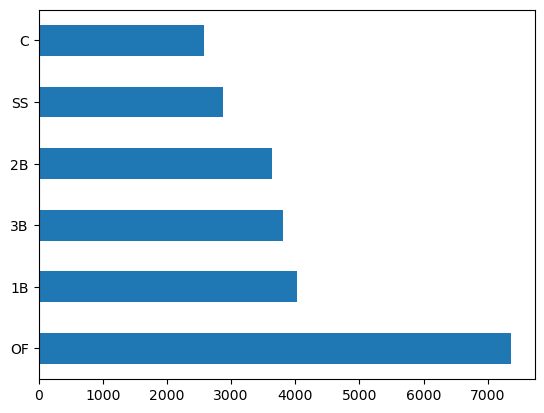

In [53]:
#display position group totals
pos['position'].value_counts().plot(kind = 'barh')

In [54]:
pos.to_csv('/Users/andrewpullar/Downloads/pos')

In [55]:
hitting_data = hitting_data.merge(pos, how = 'left', left_on = ['player_ID','season'],
                          right_on = ['playerID','season'])

In [56]:
hitting_data.head(10)

,player,season,mlb_ID,player_ID,team_ID,lg_ID,pitcher,G_x,PA_x,salary,...,HardHit,HardHit%,Events,CStr%,CSW%,xBA,xSLG,xwOBA,playerID,position
0,Barry Bonds,2001,111188.0,bondsba01,SFG,NL,N,153,664.0,10300000.0,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,bondsba01,OF
1,Barry Bonds,2002,111188.0,bondsba01,SFG,NL,N,143,612.0,15000000.0,...,NaN,NaN,0.0,0.127,0.191,NaN,NaN,NaN,bondsba01,OF
2,Mookie Betts,2018,605141.0,bettsmo01,BOS,AL,N,136,614.0,10500000.0,...,217.0,0.500,434.0,0.220,0.270,NaN,NaN,NaN,bettsmo01,2B
3,Mookie Betts,2018,605141.0,bettsmo01,BOS,AL,N,136,614.0,10500000.0,...,217.0,0.500,434.0,0.220,0.270,NaN,NaN,NaN,bettsmo01,OF
4,Barry Bonds,2004,111188.0,bondsba01,SFG,NL,N,147,617.0,18000000.0,...,NaN,NaN,0.0,0.124,0.164,NaN,NaN,NaN,bondsba01,OF
5,Mike Trout,2012,545361.0,troutmi01,LAA,AL,N,139,639.0,492500.0,...,0.0,NaN,0.0,0.221,0.293,NaN,NaN,NaN,troutmi01,OF
6,Mike Trout,2016,545361.0,troutmi01,LAA,AL,N,159,681.0,16083000.0,...,167.0,0.400,417.0,0.188,0.259,NaN,NaN,NaN,troutmi01,OF
7,Sammy Sosa,2001,122544.0,sosasa01,CHC,NL,N,160,711.0,12500000.0,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,sosasa01,OF
8,Mike Trout,2018,545361.0,troutmi01,LAA,AL,N,140,608.0,34083000.0,...,162.0,0.460,352.0,0.201,0.261,NaN,NaN,NaN,troutmi01,OF
9,Bryce Harper,2015,547180.0,harpebr03,WSN,NL,N,153,654.0,2500000.0,...,188.0,0.477,394.0,0.118,0.226,NaN,NaN,NaN,harpebr03,OF


In [57]:
avg_salary_by_position = hitting_data.groupby("position").mean()['salary']

/var/folders/w8/52vxmf0s1sdgnnq8pmnkr7wm0000gn/T/ipykernel_29001/1593182446.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_salary_by_position = hitting_data.groupby("position").mean()['salary']


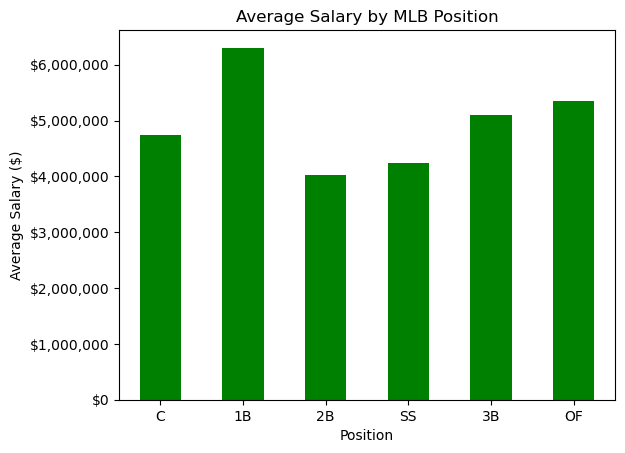

In [58]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Plot the average salary by position as a bar chart
position_order = ['C', '1B', '2B', 'SS', '3B', 'OF']
avg_salary_by_position = avg_salary_by_position.reindex(position_order)
avg_salary_by_position.plot(kind='bar', x='Position', y='Salary', color='green')

# Add labels and title to the plot
plt.xlabel('Position')
plt.xticks(rotation = 0)
plt.ylabel('Average Salary ($)')
plt.title('Average Salary by MLB Position')

# Format the y-axis labels as decimal values
formatter = ticker.StrMethodFormatter('${x:,.0f}')
plt.gca().yaxis.set_major_formatter(formatter)

# Show the plot
plt.show()

In [59]:
#check for missing values
hitting_data.isnull().sum()

player          0
season          0
mlb_ID          0
player_ID       0
team_ID         0
             ... 
xBA          4621
xSLG         4621
xwOBA        4621
playerID       50
position       50
Length: 333, dtype: int64

In [61]:
#check salary for missing values
column_name = "salary"
missing_values = hitting_data[column_name].isna().sum()

if missing_values > 0:
    print(f"There are {missing_values} missing values in column '{column_name}'.")
else:
    print(f"There are no missing values in column '{column_name}'.")


There are no missing values in column 'salary'.


In [63]:
columns = ['Name', 'Season', 'position','team_ID', 'Age', 'salary', 'G_y', 'AB', 'PA_y', 
                          'H', '1B', '2B', '3B', 'HR', 'R', 'RBI', 'BB', 'BB%', 'AVG','IBB', 
                         'SO', 'K%', 'BB/K','HBP', 'SF', 'SH', 'GDP', 'SB', 'CS', 'OBP', 'SLG', 'OPS', 'WAR_x', 'WAR_y', 'wOBA']

df = hitting_data[columns]


In [71]:
#display duplicate player seasons
duplicates = df[df.duplicated(keep = False)]
duplicates

,Name,Season,position,team_ID,Age,salary,G_y,AB,PA_y,H,...,SH,GDP,SB,CS,OBP,SLG,OPS,WAR_x,WAR_y,wOBA
1042,Joey Gallo,2021.0,OF,TEX,27.0,6200000.0,153.0,498.0,616.0,99.0,...,0.0,6.0,6.0,0.0,0.351,0.458,0.808,4.20,4.2,0.348
1043,Joey Gallo,2021.0,OF,TEX,27.0,6200000.0,153.0,498.0,616.0,99.0,...,0.0,6.0,6.0,0.0,0.351,0.458,0.808,4.20,4.2,0.348
1124,Mark Teixeira,2008.0,1B,ATL,28.0,12500000.0,157.0,574.0,685.0,177.0,...,0.0,17.0,2.0,0.0,0.410,0.552,0.962,4.09,6.9,0.410
1125,Mark Teixeira,2008.0,1B,ATL,28.0,12500000.0,157.0,574.0,685.0,177.0,...,0.0,17.0,2.0,0.0,0.410,0.552,0.962,4.09,6.9,0.410
1167,Trea Turner,2021.0,SS,WSN,28.0,13000000.0,148.0,595.0,646.0,195.0,...,0.0,18.0,32.0,5.0,0.375,0.536,0.911,4.01,6.8,0.386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4542,Alberto Callaspo,2010.0,3B,KCR,27.0,460000.0,146.0,562.0,601.0,149.0,...,1.0,22.0,5.0,3.0,0.302,0.374,0.675,1.06,0.9,0.297
4572,Nick Castellanos,2019.0,OF,DET,27.0,9950000.0,151.0,615.0,664.0,178.0,...,0.0,12.0,2.0,2.0,0.337,0.525,0.863,1.04,2.5,0.357
4573,Nick Castellanos,2019.0,OF,DET,27.0,9950000.0,151.0,615.0,664.0,178.0,...,0.0,12.0,2.0,2.0,0.337,0.525,0.863,1.04,2.5,0.357
4594,Hunter Pence,2012.0,OF,PHI,29.0,10400000.0,160.0,617.0,688.0,156.0,...,1.0,15.0,5.0,2.0,0.319,0.425,0.743,1.01,1.8,0.323


From the displayed rows above, it is apparent that there are multiple duplicate players in the dataframe. These duplicates need to be removed. 

In [72]:
df.drop_duplicates(subset=['Name', 'Season'], keep='first', inplace=True)

In [73]:
duplicates = df[df.duplicated(keep = False)]
duplicates

,Name,Season,position,team_ID,Age,salary,G_y,AB,PA_y,H,...,SH,GDP,SB,CS,OBP,SLG,OPS,WAR_x,WAR_y,wOBA


In [75]:
cpi = pd.read_csv('/Users/andrewpullar/Downloads//CPI (1960 - 2022).csv')
cpi.head()


,Year,January
0,1960,29.37
1,1961,29.84
2,1962,30.04
3,1963,30.44
4,1964,30.94


In [76]:
# clean the cpi csv
cpi = cpi[:62]
cpi = cpi[['Year', 'January']]
cpi = cpi.rename({'Jan': 'CPI'}, axis = 'columns')


In [77]:
# join batting basic to cpi
df = df.merge(cpi, left_on='Season', right_on='Year', how='left')

In [78]:
#adjusted salary
df['salary_adjusted'] = round((df['salary'] * 262.2) / df['January'],0)

In [79]:
df

,Name,Season,position,team_ID,Age,salary,G_y,AB,PA_y,H,...,OBP,SLG,OPS,WAR_x,WAR_y,wOBA,Team,Year,January,salary_adjusted
0,Barry Bonds,2001.0,OF,SFG,36.0,10300000.0,153.0,476.0,664.0,156.0,...,0.515,0.863,1.379,11.85,12.5,0.537,SFG,2001,175.600,15379613.0
1,Barry Bonds,2002.0,OF,SFG,37.0,15000000.0,143.0,403.0,612.0,149.0,...,0.582,0.799,1.381,11.75,12.7,0.544,SFG,2002,177.700,22132808.0
2,Mookie Betts,2018.0,2B,BOS,25.0,10500000.0,136.0,520.0,614.0,180.0,...,0.438,0.640,1.078,10.68,10.5,0.449,BOS,2018,248.743,11068050.0
3,Barry Bonds,2004.0,OF,SFG,39.0,18000000.0,147.0,373.0,617.0,135.0,...,0.609,0.812,1.422,10.64,11.9,0.537,SFG,2004,186.300,25333333.0
4,Mike Trout,2012.0,OF,LAA,20.0,492500.0,139.0,559.0,639.0,182.0,...,0.399,0.564,0.963,10.54,10.1,0.409,LAA,2012,227.842,566768.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2882,Jhonny Peralta,2009.0,3B,CLE,27.0,3650000.0,151.0,582.0,645.0,148.0,...,0.316,0.375,0.690,1.00,0.7,0.307,CLE,2009,211.933,4515720.0
2883,Bernie Williams,2003.0,OF,NYY,34.0,12357143.0,119.0,445.0,521.0,117.0,...,0.367,0.411,0.778,1.00,0.0,0.341,NYY,2003,182.600,17743937.0
2884,Jed Lowrie,2014.0,SS,OAK,30.0,5250000.0,136.0,502.0,566.0,125.0,...,0.321,0.355,0.676,1.00,1.7,0.300,OAK,2014,235.288,5850490.0
2885,Ike Davis,2012.0,1B,NYM,25.0,506690.0,156.0,519.0,584.0,118.0,...,0.308,0.462,0.771,1.00,1.0,0.331,NYM,2012,227.842,583098.0


In [80]:
df.drop(['Team', 'Year', 'January'], axis=1, inplace = True)

In [81]:
df

,Name,Season,position,team_ID,Age,salary,G_y,AB,PA_y,H,...,GDP,SB,CS,OBP,SLG,OPS,WAR_x,WAR_y,wOBA,salary_adjusted
0,Barry Bonds,2001.0,OF,SFG,36.0,10300000.0,153.0,476.0,664.0,156.0,...,5.0,13.0,3.0,0.515,0.863,1.379,11.85,12.5,0.537,15379613.0
1,Barry Bonds,2002.0,OF,SFG,37.0,15000000.0,143.0,403.0,612.0,149.0,...,4.0,9.0,2.0,0.582,0.799,1.381,11.75,12.7,0.544,22132808.0
2,Mookie Betts,2018.0,2B,BOS,25.0,10500000.0,136.0,520.0,614.0,180.0,...,5.0,30.0,6.0,0.438,0.640,1.078,10.68,10.5,0.449,11068050.0
3,Barry Bonds,2004.0,OF,SFG,39.0,18000000.0,147.0,373.0,617.0,135.0,...,5.0,6.0,1.0,0.609,0.812,1.422,10.64,11.9,0.537,25333333.0
4,Mike Trout,2012.0,OF,LAA,20.0,492500.0,139.0,559.0,639.0,182.0,...,7.0,49.0,5.0,0.399,0.564,0.963,10.54,10.1,0.409,566768.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2882,Jhonny Peralta,2009.0,3B,CLE,27.0,3650000.0,151.0,582.0,645.0,148.0,...,20.0,0.0,2.0,0.316,0.375,0.690,1.00,0.7,0.307,4515720.0
2883,Bernie Williams,2003.0,OF,NYY,34.0,12357143.0,119.0,445.0,521.0,117.0,...,21.0,5.0,0.0,0.367,0.411,0.778,1.00,0.0,0.341,17743937.0
2884,Jed Lowrie,2014.0,SS,OAK,30.0,5250000.0,136.0,502.0,566.0,125.0,...,14.0,0.0,0.0,0.321,0.355,0.676,1.00,1.7,0.300,5850490.0
2885,Ike Davis,2012.0,1B,NYM,25.0,506690.0,156.0,519.0,584.0,118.0,...,10.0,0.0,2.0,0.308,0.462,0.771,1.00,1.0,0.331,583098.0


In [125]:
df.describe()

,Age,salary,G_y,AB,PA_y,H,1B,2B,3B,HR,...,GDP,SB,CS,OBP,SLG,OPS,WAR_x,WAR_y,wOBA,salary_adjusted
count,2887.000000,2.887000e+03,2887.000000,2887.000000,2887.000000,2887.000000,2887.000000,2887.000000,2887.000000,2887.000000,...,2887.000000,2887.000000,2887.000000,2887.000000,2887.000000,2887.000000,2887.000000,2887.000000,2887.000000,2.887000e+03
mean,28.747835,5.530364e+06,138.901282,505.411153,570.317631,140.879113,90.204364,28.667821,2.890890,19.116037,...,11.246276,9.608590,3.490475,0.349557,0.458234,0.807778,3.250603,3.101386,0.348087,6.657342e+06
std,3.730455,5.905543e+06,18.110339,89.581422,100.313275,31.316565,24.289583,8.611473,2.673413,10.609984,...,5.318801,10.740783,3.286266,0.033908,0.067840,0.093058,1.732738,1.800459,0.034842,6.916021e+06
min,19.000000,2.000000e+05,75.000000,279.000000,350.000000,56.000000,25.000000,5.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.244000,0.274000,0.555000,1.000000,-3.400000,0.251000,2.951040e+05
25%,26.000000,5.615000e+05,128.000000,440.000000,496.500000,117.000000,72.000000,22.000000,1.000000,11.000000,...,7.000000,2.000000,1.000000,0.326000,0.410000,0.743000,1.890000,1.800000,0.324000,6.178890e+05
50%,28.000000,3.500000e+06,144.000000,520.000000,586.000000,142.000000,89.000000,28.000000,2.000000,18.000000,...,11.000000,6.000000,3.000000,0.347000,0.453000,0.798000,2.870000,2.700000,0.345000,4.307777e+06
75%,31.000000,8.000000e+06,154.000000,577.000000,654.000000,164.000000,106.000000,34.000000,4.000000,26.000000,...,15.000000,13.000000,5.000000,0.369000,0.501000,0.861500,4.200000,4.100000,0.369000,1.022711e+07
max,45.000000,3.683333e+07,163.000000,716.000000,778.000000,262.000000,225.000000,58.000000,23.000000,73.000000,...,32.000000,70.000000,24.000000,0.609000,0.863000,1.422000,11.850000,12.700000,0.544000,4.082705e+07


In [82]:
df.to_csv('/Users/andrewpullar/Downloads/df')

In [83]:
# load df
#df = pd.read_csv('/Users/andrewpullar/Downloads/df.csv', index_col = 0)
df = df.drop(columns = ['Season', 'Name'])
df

,position,team_ID,Age,salary,G_y,AB,PA_y,H,1B,2B,...,GDP,SB,CS,OBP,SLG,OPS,WAR_x,WAR_y,wOBA,salary_adjusted
0,OF,SFG,36.0,10300000.0,153.0,476.0,664.0,156.0,49.0,32.0,...,5.0,13.0,3.0,0.515,0.863,1.379,11.85,12.5,0.537,15379613.0
1,OF,SFG,37.0,15000000.0,143.0,403.0,612.0,149.0,70.0,31.0,...,4.0,9.0,2.0,0.582,0.799,1.381,11.75,12.7,0.544,22132808.0
2,2B,BOS,25.0,10500000.0,136.0,520.0,614.0,180.0,96.0,47.0,...,5.0,30.0,6.0,0.438,0.640,1.078,10.68,10.5,0.449,11068050.0
3,OF,SFG,39.0,18000000.0,147.0,373.0,617.0,135.0,60.0,27.0,...,5.0,6.0,1.0,0.609,0.812,1.422,10.64,11.9,0.537,25333333.0
4,OF,LAA,20.0,492500.0,139.0,559.0,639.0,182.0,117.0,27.0,...,7.0,49.0,5.0,0.399,0.564,0.963,10.54,10.1,0.409,566768.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2882,3B,CLE,27.0,3650000.0,151.0,582.0,645.0,148.0,101.0,35.0,...,20.0,0.0,2.0,0.316,0.375,0.690,1.00,0.7,0.307,4515720.0
2883,OF,NYY,34.0,12357143.0,119.0,445.0,521.0,117.0,82.0,19.0,...,21.0,5.0,0.0,0.367,0.411,0.778,1.00,0.0,0.341,17743937.0
2884,SS,OAK,30.0,5250000.0,136.0,502.0,566.0,125.0,87.0,29.0,...,14.0,0.0,0.0,0.321,0.355,0.676,1.00,1.7,0.300,5850490.0
2885,1B,NYM,25.0,506690.0,156.0,519.0,584.0,118.0,60.0,26.0,...,10.0,0.0,2.0,0.308,0.462,0.771,1.00,1.0,0.331,583098.0


/var/folders/w8/52vxmf0s1sdgnnq8pmnkr7wm0000gn/T/ipykernel_29001/4283925616.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrm = df.corr()


<AxesSubplot:>

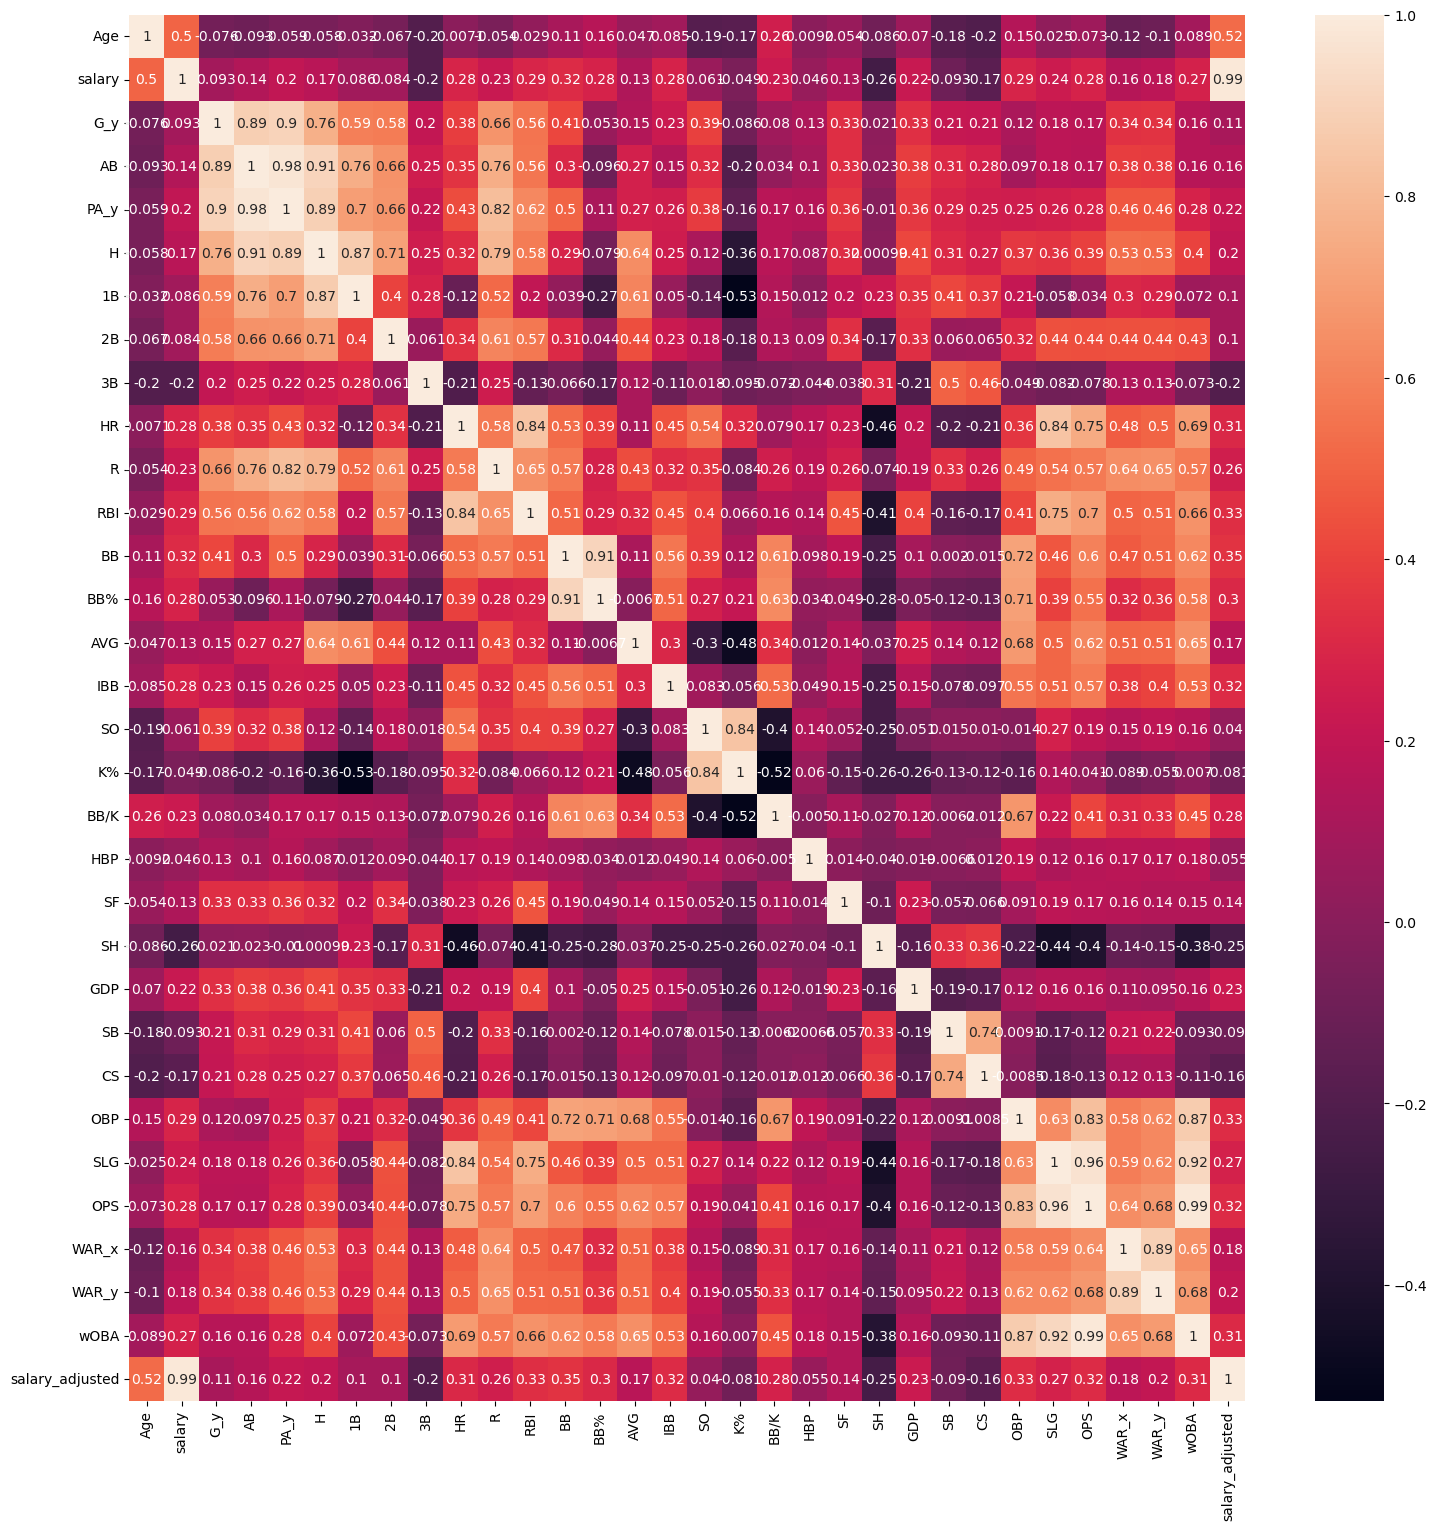

In [85]:
#correlation matrix
corrm = df.corr()
fg, x = mplt.subplots(figsize = (18, 18))
sea.heatmap(corrm, cbar = True, annot = True, vmax = 1, cmap = 'rocket')

In [86]:
ct = corrm['salary_adjusted'].sort_values(ascending=False)
ct

salary_adjusted    1.000000
salary             0.987117
Age                0.524863
BB                 0.347693
RBI                0.327891
OBP                0.325268
IBB                0.319469
OPS                0.317683
wOBA               0.313496
HR                 0.306409
BB%                0.302956
BB/K               0.276330
SLG                0.273232
R                  0.257351
GDP                0.233220
PA_y               0.216859
WAR_y              0.200870
H                  0.195109
WAR_x              0.176843
AVG                0.165044
AB                 0.156283
SF                 0.143939
G_y                0.106341
2B                 0.103982
1B                 0.102532
HBP                0.055464
SO                 0.040113
K%                -0.081044
SB                -0.089785
CS                -0.161580
3B                -0.197033
SH                -0.251674
Name: salary_adjusted, dtype: float64

In [91]:
baseball = df

In [92]:
baseball['salary_diff'] = baseball['salary_adjusted'].diff()
baseball = baseball.fillna(0)
baseball

,Name,Season,position,team_ID,Age,salary,G_y,AB,PA_y,H,...,SB,CS,OBP,SLG,OPS,WAR_x,WAR_y,wOBA,salary_adjusted,salary_diff
0,Barry Bonds,2001.0,OF,SFG,36.0,10300000.0,153.0,476.0,664.0,156.0,...,13.0,3.0,0.515,0.863,1.379,11.85,12.5,0.537,15379613.0,0.0
1,Barry Bonds,2002.0,OF,SFG,37.0,15000000.0,143.0,403.0,612.0,149.0,...,9.0,2.0,0.582,0.799,1.381,11.75,12.7,0.544,22132808.0,6753195.0
2,Mookie Betts,2018.0,2B,BOS,25.0,10500000.0,136.0,520.0,614.0,180.0,...,30.0,6.0,0.438,0.640,1.078,10.68,10.5,0.449,11068050.0,-11064758.0
3,Barry Bonds,2004.0,OF,SFG,39.0,18000000.0,147.0,373.0,617.0,135.0,...,6.0,1.0,0.609,0.812,1.422,10.64,11.9,0.537,25333333.0,14265283.0
4,Mike Trout,2012.0,OF,LAA,20.0,492500.0,139.0,559.0,639.0,182.0,...,49.0,5.0,0.399,0.564,0.963,10.54,10.1,0.409,566768.0,-24766565.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2882,Jhonny Peralta,2009.0,3B,CLE,27.0,3650000.0,151.0,582.0,645.0,148.0,...,0.0,2.0,0.316,0.375,0.690,1.00,0.7,0.307,4515720.0,-1403793.0
2883,Bernie Williams,2003.0,OF,NYY,34.0,12357143.0,119.0,445.0,521.0,117.0,...,5.0,0.0,0.367,0.411,0.778,1.00,0.0,0.341,17743937.0,13228217.0
2884,Jed Lowrie,2014.0,SS,OAK,30.0,5250000.0,136.0,502.0,566.0,125.0,...,0.0,0.0,0.321,0.355,0.676,1.00,1.7,0.300,5850490.0,-11893447.0
2885,Ike Davis,2012.0,1B,NYM,25.0,506690.0,156.0,519.0,584.0,118.0,...,0.0,2.0,0.308,0.462,0.771,1.00,1.0,0.331,583098.0,-5267392.0


In [93]:
cm = baseball.corr()
ct = cm['salary_adjusted'].sort_values(ascending=False)
ct

/var/folders/w8/52vxmf0s1sdgnnq8pmnkr7wm0000gn/T/ipykernel_29001/2299608524.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cm = baseball.corr()


salary_adjusted    1.000000
salary             0.987117
salary_diff        0.692377
Age                0.524863
BB                 0.347693
RBI                0.327891
OBP                0.325268
IBB                0.319469
OPS                0.317683
wOBA               0.313496
HR                 0.306409
BB%                0.302956
BB/K               0.276330
SLG                0.273232
R                  0.257351
GDP                0.233220
PA_y               0.216859
WAR_y              0.200870
H                  0.195109
WAR_x              0.176843
AVG                0.165044
AB                 0.156283
SF                 0.143939
G_y                0.106341
2B                 0.103982
1B                 0.102532
Season             0.068043
HBP                0.055464
SO                 0.040113
K%                -0.081044
SB                -0.089785
CS                -0.161580
3B                -0.197033
SH                -0.251674
Name: salary_adjusted, dtype: float64

In [95]:
from sklearn.model_selection import train_test_split
X = baseball[['Age', 'BB', 'RBI', 'salary_diff', 'OBP', 'IBB', 'OPS', 'HR' ]]

y = baseball['salary_adjusted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [96]:
#handle numeric and categorical variables
cc = X_train.select_dtypes(['object']).columns

nc = X_train.select_dtypes(['int', 'float']).columns

In [97]:
from sklearn.preprocessing import OneHotEncoder, MaxAbsScaler, StandardScaler

In [98]:
#scale and hot encode data
np = Pipeline([('numnorm', StandardScaler())])

nomp = Pipeline([('onehotenc', OneHotEncoder(categories="auto", sparse = False))]) 

In [99]:
from sklearn.compose import ColumnTransformer

In [100]:
ctc = ColumnTransformer(transformers = [("nominalpipe", nomp, cc), ("numpipe", np, nc)])

In [101]:
from pickle import dump, load

In [102]:
#save
dump(ctc, open('/Users/andrewpullar/Downloads/ctc.pkl', 'wb'))

In [103]:
ctc = load(open('/Users/andrewpullar/Downloads/ctc.pkl', 'rb'))

In [104]:
#column transform for train
bt = pd.DataFrame(ctc.fit_transform(X_train))
bt.head()

,0,1,2,3,4,5,6,7
0,-0.737036,1.137200,-1.028310,-0.692415,0.969762,-0.592832,-0.505833,-1.333112
1,0.325935,-0.139424,1.878695,-0.694446,-0.886963,-0.255843,0.237129,1.479959
2,2.983360,0.124705,-1.396804,0.430369,0.498213,-0.592832,-0.301249,-1.145574
3,-1.534263,0.212748,0.240946,-1.039822,0.468741,-0.255843,0.818578,0.448499
4,-1.002778,0.652964,-1.110197,-0.636445,0.380326,-0.255843,-0.139736,-1.333112


In [105]:
#column transform for test
btest = pd.DataFrame(ctc.transform(X_test))
btest.head()

,0,1,2,3,4,5,6,7
0,0.060192,0.344813,-0.496042,-0.738539,0.498213,-0.424337,-0.032060,-0.676729
1,-1.534263,-0.403553,0.486608,-0.109441,-0.562773,0.081146,0.021778,0.636037
2,1.123162,0.388835,-0.086604,1.075894,0.468741,-0.255843,0.506318,0.260961
3,-1.534263,0.917093,-0.414154,-0.506051,0.439269,0.081146,0.387875,0.448499
4,-0.471293,-1.328005,-0.905479,-0.640133,-0.975378,-0.592832,-1.238028,-1.520650


In [106]:
ltr = np.log(y_train)
lts = np.log(y_test)

In [140]:
#LR
preprocessor = ctc
model = LinearRegression()

lrp = Pipeline([('preprocess', preprocessor),('model', model)])

lrp.fit(X_train, ltr)

mod_accuracy = lrp.score(X_test, y_test)

print("Model Accuracy: ", mod_accuracy)

Model Accuracy: 0.58


In [119]:
#SVR
from sklearn.model_selection import GridSearchCV
preprocessor = ctc
svr_model = svm.SVR()

pl_svr = Pipeline([('preprocess', preprocessor), ('model', svr_model)])

#set svm parameters 
kernel = ['rbf']
C = [0.1, 1]
degree = [2, 4]

svr_sm = {'model__kernel': kernel, 'model__C': C, 'model__degree': degree}  

#base search on R-squared
svr = GridSearchCV(estimator = pl_svr, param_grid = svr_sm, scoring = 'r2')

svr.fit(X_train, ltr)

print("Model accuracy:", round(svr.best_score_,2), "\n\nBest model parameters:\n")

# create a dataframe from the ensemble_model.best_params_ dictionary
svr_best = pd.DataFrame.from_dict(sv.best_params_, orient='index', columns=['Value'])

# display the dataframe
print(svr_best)

Model accuracy: 0.67 

Best model parameters:

              Value
model__C          1
model__degree     2
model__kernel   rbf


In [117]:
#GBR
preprocessor = ctc
gbr_model = GradientBoostingRegressor()
pl_gbr = Pipeline([('preprocess', preprocessor), ('model', gbr_model)])

#parameters for gbr model
para = {'model__learning_rate': [0.1], 'model__n_estimators': [130], 'model__max_depth': [2],
                'model__max_features': [7]}

sgbr = GridSearchCV(pl_gbr, para, scoring = 'r2')

#fit model 
sgbr.fit(X_train, ltr)

print("Model accuracy:", round(sgbr.best_score_,2), "\n\nBest model parameters:\n")

#present optimal parameters
bpara = pd.DataFrame.from_dict(sgbr.best_params_, orient='index', columns=['Value'])

# display the dataframe
print(bpara)



Model accuracy: 0.72 

Best model parameters:

                      Value
model__learning_rate    0.1
model__max_depth        2.0
model__max_features     7.0
model__n_estimators   130.0


In [122]:
joblib.dump(ensemble_model, "/Users/andrewpullar/Downloads/df_model.pkl")

['/Users/andrewpullar/Downloads/df_model.pkl']

In [123]:
#save model for implementation in Streamlit app
dump(ensemble_model, open('/Users/andrewpullar/Downloads/df_model.pkl', 'wb'))

### <center> References <center>
    
    

Ledoux, J. (2022, December 9). pybaseball. Github. https://github.com/jldbc/pybaseball

PyPI. (2021, April 27). <i> pybaseball 2.2.4. </i> PyPI. https://pypi.org/project/pybaseball/


